# Creating a Kaggle Workflow

I'm going to explore a workflow to make competing in the [Kaggle Titanic](https://www.kaggle.com/c/titanic) competition easier, using a pipeline of functions.

## Read the Dataset

In [1]:
import pandas as pd
train=pd.read_csv("train.csv")  #The dataset used to train the models
holdout=pd.read_csv("test.csv")  #The test dataset

In [2]:
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


## Preprocessing the Data

Now I'll clean the dataset and make some dummy columns from the categorical columns.

In [6]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [7]:
def features_preparation(df):
    df=process_missing(df)
    df=process_age(df)
    df=process_fare(df)
    df=process_titles(df)
    df=process_cabin(df)
    cols=[
        "Age_categories",
        "Fare_categories",
        "Title",
        "Cabin_type",
        "Sex"
    ]
    for col in cols:
        df=create_dummies(df,col)
    return df

In [8]:
mod_train=features_preparation(train)
mod_holdout=features_preparation(holdout)

In [9]:
print(mod_train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_categories',
       'Fare_categories', 'Title', 'Cabin_type', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male'],
      dtype='object')


## Exploring the Data

I'm going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

In [10]:
import matplotlib.pyplot as plt

In [11]:
print(mod_train.dtypes)

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Fare_categories               category
Title                           object
Cabin_type                      object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

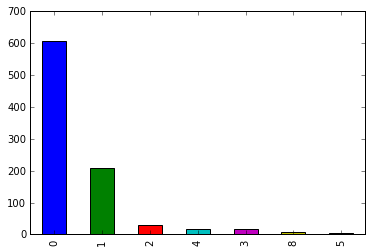

In [12]:
%matplotlib inline
mod_train["SibSp"].value_counts().plot.bar()

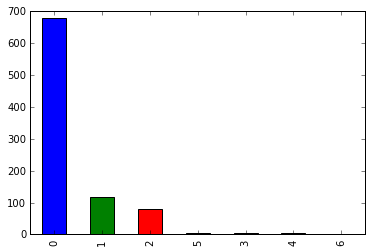

In [13]:
mod_train["Parch"].value_counts().plot.bar()

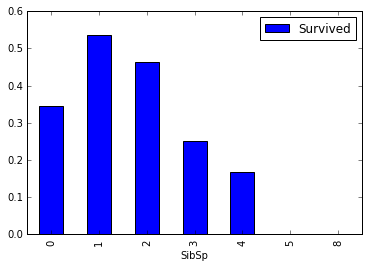

In [14]:
sibsp_pivot = mod_train.pivot_table(index="SibSp",values="Survived")
sibsp_pivot.plot.bar()

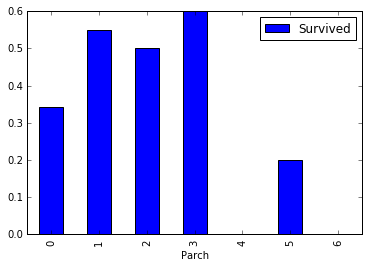

In [15]:
parch_pivot = mod_train.pivot_table(index="Parch",values="Survived")
parch_pivot.plot.bar()

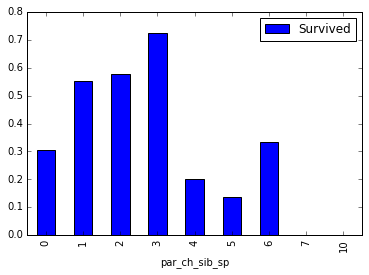

In [16]:
mod_train["par_ch_sib_sp"]=mod_train["Parch"]+mod_train["SibSp"]
par_ch_sib_sp_pivot = mod_train.pivot_table(index="par_ch_sib_sp",values="Survived")
par_ch_sib_sp_pivot.plot.bar()

The majority of people with 1, 2 or 3 family members in the ship survived, probably because most of this passengers were richer respect to the others.

## Engineering New Features

A promising new feature is a column telling if the passenger was alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard;
- 0 if the passenger has one or more family members onboard.

Let's go ahead and create this feature.

In [22]:
def isalone(df):
    df["isalone"]=0
    df.loc[(df["par_ch_sib_sp"] == 0),"isalone"] = 1
    return df
mod_train=isalone(mod_train)

In [23]:
mod_holdout["par_ch_sib_sp"]=mod_holdout["Parch"]+mod_holdout["SibSp"]
mod_holdout=isalone(mod_holdout)
print(mod_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare   ...    Cabin_type_D Cabin_type_E  \
0      0         A/5 21171   7.2500   ...               0            0   
1      0          PC 17599  71.2833   ...               0            0   
2      0  STON/O2. 3101282   7.9250   ...               0            0   
3      0            1138

## Selecting the Best-Performing Features

I can use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

To speed up the Kaggle workflow, I can create a function that performs this step.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import numpy as np

In [28]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = list(all_X.columns[selector.support_])
    print(optimized_columns)
    return optimized_columns

In [29]:
optimized_features = select_features(mod_train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'par_ch_sib_sp', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [30]:
mod_train=mod_train.drop("par_ch_sib_sp",axis=1)
optimized_features = select_features(mod_train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

Just as feature selection, I can write a function to do the heavy lifting of model selection and tuning. The function  creatd in the next step will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

This can be achieved by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model.
- An estimator object for the model.
- A dictionary of hyperparameters that we'll use for grid search.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    algorithm_list=[
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [4,6,9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        }
        
    ]
    for model in algorithm_list:
        print(model["name"])
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        best_params=grid.best_params_
        best_score=grid.best_score_
        best_estimator = grid.best_estimator_
        model["best_parameters"]=best_params
        model["best_score"]=best_score
        model["best_estimator"]=best_estimator
        print("The best parameters for ", model["name"], " are: ", best_params)
        print("with a score of: ", best_score)
    return algorithm_list

In [33]:
optimized_models = select_model(mod_train, optimized_features)
print(optimized_models)

LogisticRegression
The best parameters for  LogisticRegression  are:  {'solver': 'liblinear'}
with a score of:  0.8204264870931538
KNeighborsClassifier
The best parameters for  KNeighborsClassifier  are:  {'algorithm': 'brute', 'weights': 'uniform', 'n_neighbors': 5, 'p': 1}
with a score of:  0.7755331088664422
RandomForestClassifier
The best parameters for  RandomForestClassifier  are:  {'n_estimators': 6, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3}
with a score of:  0.8417508417508418
[{'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'best_parameters': {'solver': 'liblinear'}, 'best_score': 0.8204264870931538, 'name': 'LogisticRegression', 'hyperparameters': {'solver': ['newton-cg', 'lbfg

### The best algorithm is Random Forest with an accuracy of 0.84.

## Making a Submission to Kaggle

In [35]:
def save_submission_file(model, columns, filename="submission.csv"):
    holdout_data = mod_holdout[columns]
    predictions = model.predict(holdout_data)
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename,index=False)

best_rf_model = optimized_models[2]["best_estimator"]
save_submission_file(best_rf_model, optimized_features)

I obtained an accuracy of 74.4% on Kaggle. Good for my first shot, but it can be improved.